**<h1>Mercari Price Suggestion Challenge</h1>**

**Problem Definition:**

  Mercari, inc. is an e-commerce company that operates in Japan and the United States and its main product is the Mercari marketplace app. This biggest community-powered shopping app wanted to offer pricing suggestions to their sellers. The problem at hand is to predict the prices of any given product given the features: train_id, name, item_condition_id, category_name, brand_name, price, shipping, item description. 

#<h2>**1 Importing various libraries for the data analysis:**</h2>

In [ ]:
!pip install stop-words

  Created wheel for stop-words: filename=stop_words-2018.7.23-cp36-none-any.whl size=32917 sha256=74ac06c833c8f8b0ccea6ece5040e0b9fa904ca9070496e4c09aa0abb149a767
  Stored in directory: /root/.cache/pip/wheels/75/37/6a/2b295e03bd07290f0da95c3adb9a74ba95fbc333aa8b0c7c78
Successfully built stop-words


In [ ]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import time
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import gc
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

import math
import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.ensemble import RandomForestRegressor
from scipy.sparse import csr_matrix
from scipy.sparse import hstack
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from prettytable import PrettyTable
import pickle
import zipfile
from tqdm import tqdm
import os
from sklearn.linear_model import Ridge

from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from stop_words import get_stop_words
from collections import Counter

import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard,EarlyStopping,ModelCheckpoint
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense,Flatten
from tensorflow.keras.models import Model
from numpy import zeros
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model
tf.keras.backend.clear_session()

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
!cat /proc/cpuinfo

#<h3>**1.1 Importing Train and test data:**</h3>

In [ ]:
train = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/self_case_study_projects/project_1/train.tsv',sep='\t')

In [ ]:
#with zipfile.ZipFile('/content/gdrive/My Drive/Colab Notebooks/self_case_study_projects/project_1/test_stg2.tsv.zip', 'r') as zip_ref:
 #   zip_ref.extractall('/content/gdrive/My Drive/Colab Notebooks/self_case_study_projects/project_1/')

In [ ]:
test = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/self_case_study_projects/project_1/test_stg2.tsv',sep='\t')

In [ ]:
train.shape

(1482535, 8)

In [ ]:
test.shape

(3460725, 7)

In [ ]:
train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


In [ ]:
print(train.columns)

Index(['train_id', 'name', 'item_condition_id', 'category_name', 'brand_name',
       'price', 'shipping', 'item_description'],
      dtype='object')


In [ ]:
print(test.columns)

Index(['test_id', 'name', 'item_condition_id', 'category_name', 'brand_name',
       'shipping', 'item_description'],
      dtype='object')


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 8 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   train_id           1482535 non-null  int64  
 1   name               1482535 non-null  object 
 2   item_condition_id  1482535 non-null  int64  
 3   category_name      1476208 non-null  object 
 4   brand_name         849853 non-null   object 
 5   price              1482535 non-null  float64
 6   shipping           1482535 non-null  int64  
 7   item_description   1482531 non-null  object 
dtypes: float64(1), int64(3), object(4)
memory usage: 90.5+ MB


In [ ]:
print(train.isnull().sum())

train_id                  0
name                      0
item_condition_id         0
category_name          6327
brand_name           632682
price                     0
shipping                  0
item_description          4
dtype: int64


# <h2>**2 Exploratory data analysis:**</h2>

Some utility functions for EDA and preprocessing:

In [ ]:
def split_categories(category):
  '''
  function that splits the category column in the dataset and creates 3 new columns:
  'main_category','sub_cat_1','sub_cat_2'
  '''
  try:
    sub_cat_1,sub_cat_2,sub_cat_3 = category.split("/")
    return sub_cat_1,sub_cat_2,sub_cat_3
  except:
    return ("No label","No label","No label")

def create_split_categories(data):
  '''
  function that creates 3 new columns using split_categories function
  : 'main_category','sub_cat_1','sub_cat_2'
  '''
  #https://medium.com/analytics-vidhya/mercari-price-suggestion-challenge-a-machine-learning-regression-case-study-9d776d5293a0
  data['main_category'],data['sub_cat_1'],data['sub_cat_2']=zip(*data['category_name'].\
                                                                apply(lambda x: split_categories(x)))

def plot_categories(category,title):
  '''
  This function takes in a category and title as input and 
  plots the bar chart for the same.
  '''
  sns.set(style="darkgrid")
  sns.barplot(x=category[:10].values, y=category[:10].index)
  plt.title(title)
  plt.xlabel('Counts', fontsize=12)
  plt.show()

def log_price(price):
    return np.log1p(price)#changes

def countwords(text):
    try:
        if text == 'No description yet':
            return 0
        else:
            text = text.lower()
            words = [w for w in text.split(" ")]
            return len(words)
    except: 
        return 0

def fill_nan(dataset):
  '''
  Function to fill the NaN values in various columns
  '''
  dataset["item_description"].fillna("No description yet",inplace=True)
  dataset["brand_name"].fillna("missing",inplace=True)
  dataset["category_name"].fillna("missing",inplace=True)

# https://stackoverflow.com/a/47091490/4084039

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"oz","ounces", phrase )
    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

def preprocess_text(dataset):
  # tqdm is for printing the status bar
    for i in ['name','brand_name','item_description']:
        preprocessed_text=[]
        for sentance in tqdm(dataset[i]):
            sent = decontracted(sentance)
            sent = sent.replace('\\r', ' ')
            sent = sent.replace('\\"', ' ')
            sent = sent.replace('\\n', ' ')
            sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
          # https://gist.github.com/sebleier/554280
            sent = ' '.join(e for e in sent.split() if e not in stopwords)
            preprocessed_text.append(sent.lower().strip())
        dataset[i] = preprocessed_text

def pickle_dump(*args,filename = 'file'):
    # Saving the objects:
    argv = args
    list_variable = [i for i in argv]
    dir_name = "/content/gdrive/My Drive/Colab Notebooks/self_case_study_projects/project_1/pickles/"
    filename_suffix = "pkl"
    #https://stackoverflow.com/questions/7132861/build-the-full-path-filename-in-python
    file_path = os.path.join(dir_name, filename + "." + filename_suffix)
    with open(file_path, 'wb') as f:
        pickle.dump(list_variable, f)

def read_pickle_dump(*args,filename = 'file'):
    argv = args
    variable_list = [i for i in argv]
    # Getting back the objects:
    dir_name = "/content/gdrive/My Drive/Colab Notebooks/self_case_study_projects/project_1/pickles/"
    filename_suffix = "pkl"
    #https://stackoverflow.com/questions/7132861/build-the-full-path-filename-in-python
    file_path = os.path.join(dir_name, filename + "." + filename_suffix)
    with open(file_path,'rb') as f:
        variable_list = pickle.load(f)
        print("Returning the variables\n")
    return variable_list

def price_history_features(train,test):
    '''
    This function adds the columns for 
    mean log price, the minimum and maximum expected log price
    around +/-2 standard deviation
    '''
    
    #https://jamesrledoux.com/code/group-by-aggregate-pandas
    #train['log_price'] = log_price(train['price'])
    df = train.groupby(['category_name','brand_name','shipping']).agg({'log_price': [np.mean, np.std]})
    df.columns = ['mean_log_price_cbs','log_price_std']
    df = df.reset_index()
    df['log_price_std'] = df['log_price_std'].fillna(0)
    df['expected_log_price_min'] = (df['mean_log_price_cbs'] - df['log_price_std']*2).clip(lower=1.0)
    df['expected_log_price_max'] = (df['mean_log_price_cbs'] + df['log_price_std']*2)

    final_df = test.merge(df, how = 'left', \
                          on = ['category_name','brand_name','shipping'])\
                          [['mean_log_price_cbs',
                           'log_price_std',
                           'expected_log_price_min',
                           'expected_log_price_max']].fillna(0).values
    #final_df = np.delete(final_df, 1, 1)
    print("Created price history features\n")
    return final_df

def numeric_scalar(train,test):
    '''
    This function standardizes the price features
    '''
    global price_scaler 
    price_scaler = StandardScaler()
    price_scaler.fit(train)
    scaled_df = price_scaler.transform(test)
    return scaled_df
def one_hot_encode(train,test):
    '''
    Function to one hot encode the categorical columns
    '''
    vectorizer = CountVectorizer(token_pattern='.+')
    
    vectorizer = vectorizer.fit(train['category_name'].values) # fit has to happen only on train data
    column_cat = vectorizer.transform(test['category_name'].values)

    #vectorizing the main_category column
    vectorizer = vectorizer.fit(train['main_category'].values) # fit has to happen only on train data
    column_mc = vectorizer.transform(test['main_category'].values)
    
    #vectorizing sub_cat_1 column
    vectorizer = vectorizer.fit(train['sub_cat_1'].values) # fit has to happen only on train data
    column_sb1 = vectorizer.transform(test['sub_cat_1'].values)
    
    #vectorizing sub_cat_2 column
    vectorizer = vectorizer.fit(train['sub_cat_2'].values) # fit has to happen only on train data
    column_sb2 = vectorizer.transform(test['sub_cat_2'].values)

    #vectorizing brand column
    vectorizer = vectorizer.fit(train['brand_name'].astype(str)) # fit has to happen only on train data
    brand_encodes = vectorizer.transform(test['brand_name'].astype(str))
   
    print("created OHE columns for main_category,sub_cat_1,sub_cat_2\n")
    print(column_cat.shape)
    print(column_mc.shape)
    print(column_sb1.shape)
    print(column_sb2.shape)
    print(brand_encodes.shape)
    print("="*100)
    return column_cat,column_mc,column_sb1,column_sb2,brand_encodes

def get_dummies_item_id_shipping(df):
    df['item_condition_id'] = df["item_condition_id"].astype("category")
    df['shipping'] = df["shipping"].astype("category")
    item_id_shipping = csr_matrix(pd.get_dummies(df[['item_condition_id', 'shipping']],\
                                                      sparse=True).values)
    return item_id_shipping

def text_features_word_count(train,test):
    '''
    This function standardizes the text word count using standardscalar
    '''
    text_wc_scalar = StandardScaler()
    text_wc_scalar.fit(train['description_wc'].values.reshape(-1,1))
    scaled_wc = text_wc_scalar.transform(test['description_wc'].values.reshape(-1,1))
    print("After standardizing and rescaling:\n")
    print(scaled_wc.shape)
    return scaled_wc

def vectorizer(train,test,column,no_of_features,n_range,vector_type):
    '''
    Function to vectorize text using TFIDF/BoW
    '''
    if str(vector_type) == 'bow':
        vectorizer = CountVectorizer(ngram_range=n_range,max_features=no_of_features).fit(train[column])  #fitting
    else:
        vectorizer = TfidfVectorizer(ngram_range=n_range, max_features=no_of_features).fit(train[column]) # fit has to happen only on train data
    
    # we use the fitted vectorizer to convert the text to vector
    transformed_text = vectorizer.transform(tqdm(test[column]))
    ###############################
    print("After vectorizations")
    print(transformed_text.shape)
    print("="*100)
    return transformed_text

def hyperparameter_tuning_random(x,y,model_estimator,param_dict,cv_no):
    start = time.time()
    hyper_tuned = GridSearchCV(estimator = model_estimator, param_grid = param_dict,\
                                    return_train_score=True, scoring = 'neg_mean_squared_error',\
                                    cv = cv_no, \
                                    verbose=2, n_jobs = -1)
    hyper_tuned.fit(x,y)
    print("\n######################################################################\n")
    print ('Time taken for hyperparameter tuning is {} sec\n'.format(time.time()-start))
    print('The best parameters_: {}'.format(hyper_tuned.best_params_))
    return hyper_tuned.best_params_

def rmsle_compute(y_true, y_pred):
    #https://www.kaggle.com/gspmoreira/cnn-glove-single-model-private-lb-0-41117-35th
    assert len(y_true) == len(y_pred)
    score = np.sqrt(np.mean(np.power(np.log1p(y_pred) - np.log1p(y_true), 2)))
    return score

def encode_brand(train,test):
    vectorizer = preprocessing.LabelBinarizer(sparse_output=True)
    transformed_tr = vectorizer.fit_transform(train["brand_name"])
    transformed_te = vectorizer.transform(test["brand_name"])
    return transformed_tr,transformed_te

def scale_back(x):
    '''
    Function to inverse transform the scaled values
    '''
    x= np.expm1(y_scalar.inverse_transform(x.reshape(-1,1))[:,0])#changes
    return x

# <h3>**2.1 Univariate analysis of category_name:**</h3>

In [ ]:
category_count = train['category_name'].value_counts()

In [ ]:
category_count

Women/Athletic Apparel/Pants, Tights, Leggings    60177
Women/Tops & Blouses/T-Shirts                     46380
Beauty/Makeup/Face                                34335
Beauty/Makeup/Lips                                29910
Electronics/Video Games & Consoles/Games          26557
                                                  ...  
Handmade/Accessories/Belt                             1
Handmade/Quilts/Bed                                   1
Other/Magazines/International Publications            1
Handmade/Pets/Tag                                     1
Vintage & Collectibles/Housewares/Towel               1
Name: category_name, Length: 1287, dtype: int64

In [ ]:
category_count_te = test['category_name'].value_counts()

In [ ]:
category_count_te

Women/Athletic Apparel/Pants, Tights, Leggings    139412
Women/Tops & Blouses/T-Shirts                     108334
Beauty/Makeup/Face                                 80054
Beauty/Makeup/Lips                                 69655
Electronics/Video Games & Consoles/Games           62577
                                                   ...  
Handmade/Children/Housewares                           1
Handmade/Toys/Doll                                     1
Handmade/Furniture/Entertainment                       1
Vintage & Collectibles/Housewares/Pillow               1
Handmade/Candles/Bookmark                              1
Name: category_name, Length: 1335, dtype: int64

There are totally 1287 categories in our train dataset and 1335 categories in test dataset. Each category is further divided into 3 subcategories.

**Splitting categories into subcategories:**

Each category column can be divided into 3 sub categories using the below function.

In [ ]:
create_split_categories(train)
create_split_categories(test)

In [ ]:
train.head(2)

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,main_category,sub_cat_1,sub_cat_2
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet,Men,Tops,T-shirts
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts


In [ ]:
test.head(2)

,test_id,name,item_condition_id,category_name,brand_name,shipping,item_description,main_category,sub_cat_1,sub_cat_2
0,0,"Breast cancer ""I fight like a girl"" ring",1,Women/Jewelry/Rings,NaN,1,Size 7,Women,Jewelry,Rings
1,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers",1,Other/Office supplies/Shipping Supplies,NaN,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers Lined...",Other,Office supplies,Shipping Supplies


Now we are counting the sub categories

In [ ]:
main_category_count = train['main_category'].value_counts()
sub_1_count = train['sub_cat_1'].value_counts()
sub_2_count = train['sub_cat_2'].value_counts()

In [ ]:
main_category_count

Women                     664385
Beauty                    207828
Kids                      171689
Electronics               119631
Men                        93363
Home                       67871
Vintage & Collectibles     46530
Other                      45351
Handmade                   30840
Sports & Outdoors          24331
                           10716
Name: main_category, dtype: int64

In [ ]:
sub_1_count

Athletic Apparel        134383
Makeup                  124624
Tops & Blouses          106960
Shoes                   100452
Jewelry                  61763
                         ...  
Candles                     64
Ceramics and Pottery        57
Dolls and Miniatures        49
Books and Zines             46
Quilts                      31
Name: sub_cat_1, Length: 114, dtype: int64

In [ ]:
sub_2_count

Pants, Tights, Leggings    60177
Other                      50224
Face                       50171
T-Shirts                   46380
Shoes                      32168
                           ...  
Pet Food                       1
Mirror                         1
Primitive                      1
Bathroom                       1
Cuff                           1
Name: sub_cat_2, Length: 865, dtype: int64

**Observation:**

There are 11 main categories which are inturn categorized into 114 sub categories (subcategory 1) which are further categorized into 865 unique categories(sub category 2) in train data.

In [ ]:
main_category_count_te = test['main_category'].value_counts()
sub_1_count_te = test['sub_cat_1'].value_counts()
sub_2_count_te = test['sub_cat_2'].value_counts()

In [ ]:
main_category_count_te

Women                     1549092
Beauty                     485171
Kids                       400135
Electronics                280006
Men                        218240
Home                       159171
Vintage & Collectibles     108512
Other                      106712
Handmade                    71620
Sports & Outdoors           57050
not given                   25016
Name: main_category, dtype: int64

In [ ]:
sub_1_count_te

Athletic Apparel        312667
Makeup                  290538
Tops & Blouses          250894
Shoes                   233276
Jewelry                 143868
                         ...  
Suits                      148
Candles                    146
Books and Zines            105
Dolls and Miniatures        98
Quilts                      80
Name: sub_cat_1, Length: 114, dtype: int64

In [ ]:
sub_2_count_te

Pants, Tights, Leggings    139412
Face                       117264
Other                      116970
T-Shirts                   108334
Shoes                       75165
                            ...  
Human Figure Doll               1
Draft Stoppers                  1
Squeegees                       1
Bench                           1
Pincushion                      1
Name: sub_cat_2, Length: 890, dtype: int64

While in test data, there are 11 main categories and 114 in sub category 1 but there are 890 sub category 2 in test.

Text(0.5, 1.0, 'Comparison of sub_cat_2 column between train and test\n')

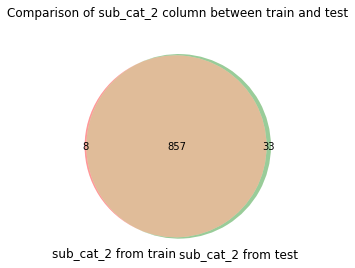

In [ ]:
from matplotlib_venn import venn2, venn2_circles
train_set = set(train['sub_cat_2'].tolist())
test_set = set(test['sub_cat_2'].tolist())
#https://www.badgrammargoodsyntax.com/compbio/2017/10/29/compbio-012-making-venn-diagrams-the-right-way-using-python
venn2([train_set, test_set], set_labels = ('sub_cat_2 from train', 'sub_cat_2 from test'))
plt.title('Comparison of sub_cat_2 column between train and test\n')

**Observation:**

From the above venn diagram we can observe that there are 857 sub_category_2 categories which are common between train and test, 8 categories are only exclusively present in train while 33 are exclusive to test data. We can get to these category details by doing a set operation as shown below. 

In [ ]:
common_sub_cat_2 = train_set.intersection(test_set)

In [ ]:
len(common_sub_cat_2)

857

sub_cat_2 that are present only in test. There are 12 of them:

In [ ]:
sub_cat_2_only_in_test = test_set.difference(train_set)
print(sub_cat_2_only_in_test,"\n")
print(len(sub_cat_2_only_in_test))

{'Rugs', 'Windchimes', 'Desk', 'Traditional', 'Portraits', 'Wall', 'Plushie', 'Album', 'Computer', 'Squeegees', 'Geometric', 'Bedroom', 'Pincushion', 'Holidays', 'Rugby', 'Pretend', 'Table Runner', 'Puppet', 'Changing Tables', 'Professional & Trade', 'Tandem', 'Messenger', 'Fiber Art', 'Zine', 'Bench', 'Amigurumi', 'Kitchen & Dining Room Furniture', 'Teapots', 'Rails & Rail Guards', 'Marbles', 'Jars', 'Puppets', 'Home'} 

33


sub_cat_2 that are present only in train. There are 49 of them:

In [ ]:
sub_cat_2_only_in_train = train_set.difference(test_set)
print(sub_cat_2_only_in_train,"\n")
print(len(sub_cat_2_only_in_train))

{'Fashion Dolls Apparel', 'Tiles', 'Artist Bears', 'International Publications', 'RV Parts & Accessories', 'Holiday Décor Storage', 'Pad', 'Child Friendly'} 

8


**Plotting categories and subcategories:**

**Below are the bar charts for different categories:**

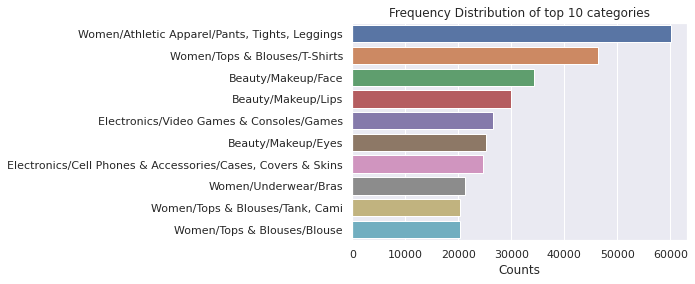

In [ ]:
#https://www.datacamp.com/community/tutorials/categorical-data

plot_categories(category_count,"Frequency Distribution of top 10 categories")

**Observation:**

The above barchart shows the top 10 categories which occur most frequently. It is observed that out of all the categories, women apparel holds the crowning point.

**Below is the bar chart for the main categories:**

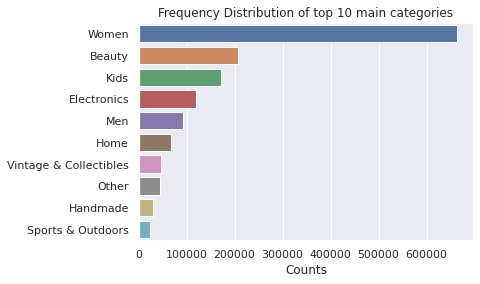

In [ ]:
plot_categories(main_category_count,"Frequency Distribution of top 10 main categories")

**Below is the bar chart for the sub-category 1:**

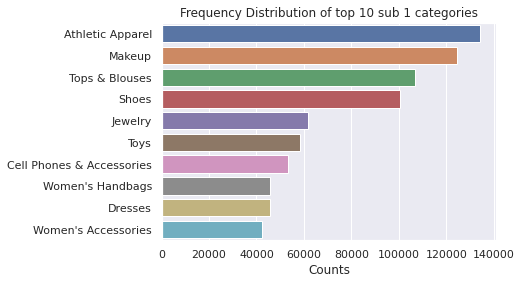

In [ ]:
plot_categories(sub_1_count,"Frequency Distribution of top 10 sub 1 categories")

**Below is the bar chart for the sub-category 2:**

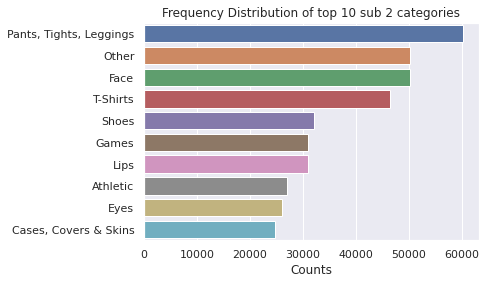

In [ ]:
plot_categories(sub_2_count,"Frequency Distribution of top 10 sub 2 categories")

# <h3>**2.2 Univariate Analysis of brand_name:**</h4>

In [ ]:
brand_count = train['brand_name'].value_counts()

In [ ]:
brand_count[:10]

PINK                 54088
Nike                 54043
Victoria's Secret    48036
LuLaRoe              31024
Apple                17322
FOREVER 21           15186
Nintendo             15007
Lululemon            14558
Michael Kors         13928
American Eagle       13254
Name: brand_name, dtype: int64

In [ ]:
brand_count.count()

4809

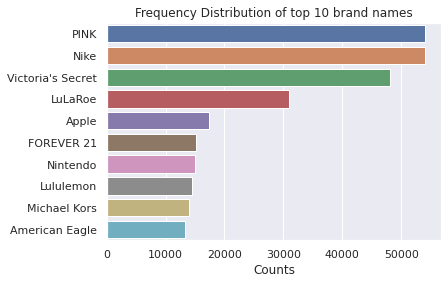

In [ ]:
#https://www.datacamp.com/community/tutorials/categorical-data

sns.barplot(x=brand_count[:10].values, y=brand_count[:10].index)
plt.title('Frequency Distribution of top 10 brand names')
plt.xlabel('Counts', fontsize=12)
plt.show()

**Observation:**

There are totally 4807 unique brands out of which the top 10 most frequently occuring brands are shown in the above bar chart. It is clearly observed that the brand PINK and NIKE followed by Victoria's Secret are the one's that hold top positions. 

#<h4>**2.3 Univariate analysis of the target variable 'Price':**</h4>

Since 'price' is numerical, we can make use of describe() function to perceive the summary statistics.

In [ ]:
train.price.describe()

count    1.482535e+06
mean     2.673752e+01
std      3.858607e+01
min      0.000000e+00
25%      1.000000e+01
50%      1.700000e+01
75%      2.900000e+01
max      2.009000e+03
Name: price, dtype: float64

**Observation:**

From describe function we decipher that the maximum price of any product is \$2009 and the minimum price that any product can have is 0. Also it is observed that 75% of the products price range is under $290 and 50% of the products price fall under \$170 while 25% of the products price fall under \$10. The mean price range is \$26.7

(array([1.393346e+06, 6.416700e+04, 1.477600e+04, 5.016000e+03,
        2.157000e+03, 1.162000e+03, 6.180000e+02, 3.400000e+02,
        2.110000e+02, 1.620000e+02, 1.360000e+02, 1.010000e+02,
        7.800000e+01, 6.100000e+01, 3.900000e+01, 3.500000e+01,
        2.000000e+01, 1.000000e+01, 2.100000e+01, 1.100000e+01,
        1.500000e+01, 3.000000e+00, 1.300000e+01, 5.000000e+00,
        3.000000e+00, 3.000000e+00, 1.000000e+01, 4.000000e+00,
        2.000000e+00, 1.000000e+01]),
 array([   0.        ,   66.96666667,  133.93333333,  200.9       ,
         267.86666667,  334.83333333,  401.8       ,  468.76666667,
         535.73333333,  602.7       ,  669.66666667,  736.63333333,
         803.6       ,  870.56666667,  937.53333333, 1004.5       ,
        1071.46666667, 1138.43333333, 1205.4       , 1272.36666667,
        1339.33333333, 1406.3       , 1473.26666667, 1540.23333333,
        1607.2       , 1674.16666667, 1741.13333333, 1808.1       ,
        1875.06666667, 1942.03333333, 

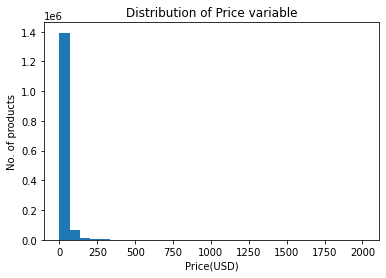

In [ ]:
plt.title("Distribution of Price variable")
plt.xlabel("Price(USD)")
plt.ylabel("No. of products")
plt.hist(train['price'],bins=30)

**Observation:**

The price feature follows a right_skewed distribution as evident from the above plot. A normally distributed target variable is much more convenient to handle for modeling, hence log transformation is applied for the price feature.

**<h4>Log transformed price distribution:</h4>**

In [ ]:
train['log_price'] = log_price(train['price'])

(array([8.74000e+02, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        1.87030e+04, 1.61390e+04, 6.38110e+04, 1.13886e+05, 2.02913e+05,
        2.50574e+05, 1.66759e+05, 2.33856e+05, 1.05214e+05, 1.07797e+05,
        8.20460e+04, 4.22870e+04, 2.93820e+04, 1.86720e+04, 1.22260e+04,
        7.43900e+03, 4.54800e+03, 2.42500e+03, 1.44000e+03, 6.95000e+02,
        3.95000e+02, 2.50000e+02, 1.12000e+02, 5.60000e+01, 3.60000e+01]),
 array([0.        , 0.25352967, 0.50705933, 0.760589  , 1.01411867,
        1.26764833, 1.521178  , 1.77470767, 2.02823733, 2.281767  ,
        2.53529667, 2.78882633, 3.042356  , 3.29588567, 3.54941533,
        3.802945  , 4.05647467, 4.31000433, 4.563534  , 4.81706367,
        5.07059333, 5.324123  , 5.57765267, 5.83118233, 6.084712  ,
        6.33824167, 6.59177133, 6.845301  , 7.09883067, 7.35236033,
        7.60589   ]),
 <a list of 30 Patch objects>)

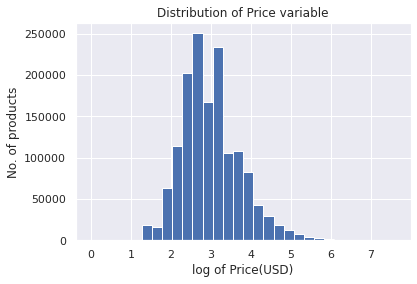

In [ ]:
sns.set(style="darkgrid")
plt.title("Distribution of Price variable")
plt.xlabel("log of Price(USD)")
plt.ylabel("No. of products")
plt.hist(train['log_price'],bins=30)

**Observation:**

After applying log transformation, it is clearly evident that distribution of log price is closer to normal distribution. We add log(x)+1 here, because we have many items whose price is zero and log(0) is undefined hence, we use log(x) + 1.

# <h4>**2.4 Univariate analysis of item_description:**</h4>

In [ ]:
train['description_wc'] = [len(str(i).split()) for i in train['item_description']]

In [ ]:
train['description_wc'].describe()

count    1.482535e+06
mean     2.568858e+01
std      3.039363e+01
min      1.000000e+00
25%      7.000000e+00
50%      1.500000e+01
75%      3.100000e+01
max      2.450000e+02
Name: description_wc, dtype: float64

**Boxplot:**

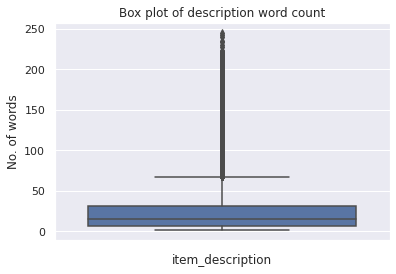

In [ ]:
sns.boxplot(train['description_wc'],orient='v')
plt.title("Box plot of description word count")
plt.xlabel("item_description")
plt.ylabel("No. of words")
plt.show()

**Observation:**

From the box plot we can see that most of the descriptions contain less than 40 words approximately.

**Density plot:**

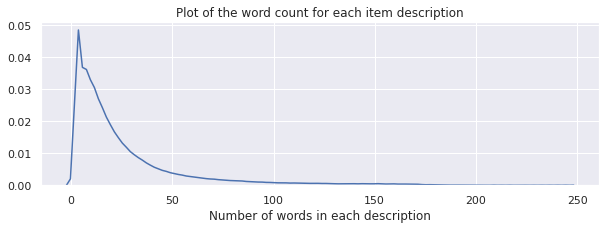

In [ ]:
plt.figure(figsize=(10,3))
sns.distplot(train['description_wc'], hist=False)
plt.title('Plot of the word count for each item description')
plt.xlabel('Number of words in each description')
plt.show()

**Observation:**

Plot of the description word count is right skewed. The minimum length of the item description is 1 while the maximum length of the description is 245. 
The mean length of the description is approximately 25 words.

Fewer descriptions are lengthy while most of the descriptions contain less than 40 words approximately.

**Word cloud from item_description:**

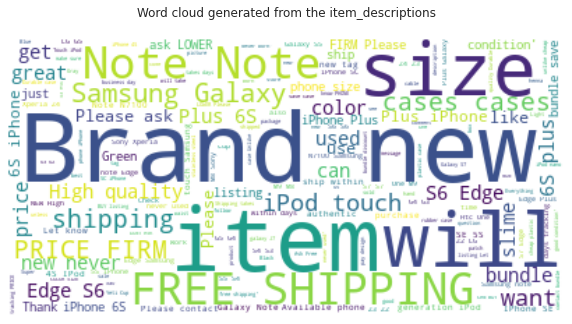

In [ ]:
word_counter = Counter(train['item_description'])
most_common_words = word_counter.most_common(500)

#https://www.geeksforgeeks.org/generating-word-cloud-python/
# Create and generate a word cloud image:
stopwords = get_stop_words('en')
#https://github.com/Alir3z4/python-stop-words/issues/19
stopwords.extend(['rm'])
wordcloud = WordCloud(stopwords=stopwords,background_color="white").generate(str(most_common_words))

# Display the generated image:
plt.figure(figsize=(10,15))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("Word cloud generated from the item_descriptions\n")
plt.axis("off")
plt.show()

**Observation:**

From the above word cloud we can see that words that are frequently appearing in our item_description are Brand, new, size, item, will, FREE SHIPPING etc.

# <h4>**2.5 Univariate analysis of item_condition_id:**</h4>

In [ ]:
y = train['item_condition_id'].value_counts()

In [ ]:
y

1    640549
3    432161
2    375479
4     31962
5      2384
Name: item_condition_id, dtype: int64

Text(0, 0.5, 'No. of items (in 1000s)')

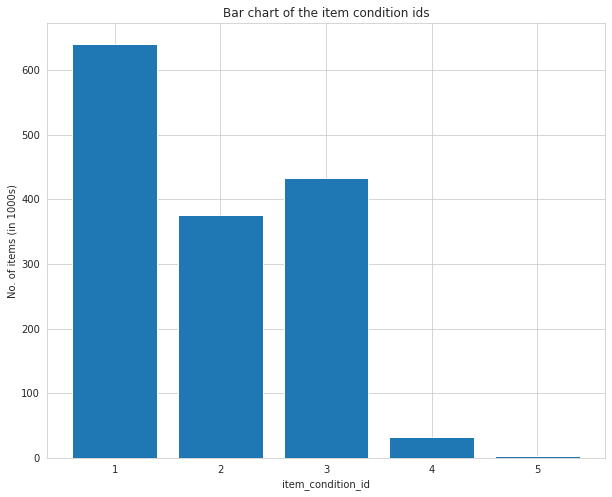

In [ ]:
plt.figure(figsize=(10,8))
plt.bar(x = [1,3,2,4,5],height=y/1000,align='center') # A bar chart
plt.title("Bar chart of the item condition ids")
plt.xlabel('item_condition_id')
plt.ylabel('No. of items (in 1000s)')

**Observation:**

The range of the item_condition_id is from 1 to 5 and this is a ordinal categorical feature. The ordinality is the item with condition 1 is 'best' and the item with condition 5 is 'worst' (based on the reference at https://www.kaggle.com/captcalculator/a-very-extensive-mercari-exploratory-analysis/code). One can observe that most of the items for sale are in a good condition as evident from the above bar chart. Accordingly, the condition 1 items are higher followed by condition 3 andd 2 while items with condition 4 and 5 are least.

#<h3>**2.6 Bivariate analysis:**</h3>


# <h4>**2.6.1 Price Vs Shipping:**</h4>

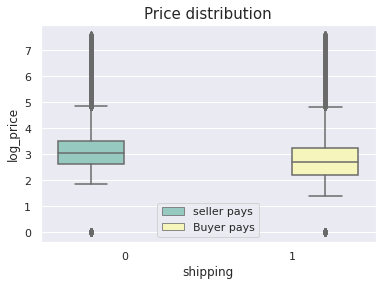

In [ ]:
#https://seaborn.pydata.org/generated/seaborn.boxplot.html

ax = sns.boxplot(x=train['shipping'],y=train['log_price'],palette="Set3",hue=train['shipping'])
handles, _ = ax.get_legend_handles_labels()
ax.legend(handles, ["seller pays", "Buyer pays"])
plt.title('Price distribution', fontsize=15)
plt.show()

**Observation:**

From the above box plot one can observe that when item price is higher then seller pays for the shipping and vice-versa.

# <h4>**2.6.2 Price Vs Description length:**</h4>

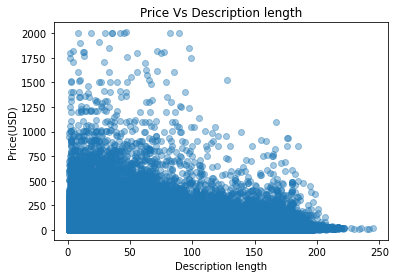

In [ ]:
plt.scatter(train['description_wc'],train['price'],alpha=0.4)
plt.title("Price Vs Description length")
plt.xlabel("Description length")
plt.ylabel("Price(USD)")
plt.show()

**Observation:**

Looking at the above plot we can observe a trend that the item with less description length tend to have high price when compared the ones with longer description.

#<h2>**3 Data preprocessing:**</h2>

#<h4>**3.1 Data cleaning:**</h4>

**The 'price' variable:**

It is seen that the minimum price in mercari website is 3. Hence in our training data we are going to retain those items whose prices are above $3

In [ ]:
#https://www.kaggle.com/valkling/mercari-rnn-2ridge-models-with-notes-0-42755
train = train.drop(train[(train.price < 3.0)].index)

In [ ]:
print(train.shape)

(1481661, 12)


#<h4>**3.2 Handling Null/Missing values:**</h4>

From EDA we get to know that 3 columns viz., category_name, brand_name and item_description holds null values. Hence we replace them with appropriate values.

Before replacing for null and missing values:

In [ ]:
print(train.isnull().sum())

train_id                  0
name                      0
item_condition_id         0
category_name          6327
brand_name           632682
price                     0
shipping                  0
item_description          4
log_price                 0
main_category             0
sub_cat_1                 0
sub_cat_2                 0
dtype: int64


Below we are applying the fill_nan function in order to fill the NaN values in the given columns. For brand_name and category_name it replaces the NaN with 'missing' while for item_description column it replaces with 'No description yet'.

In [ ]:
fill_nan(train)
fill_nan(test)

After filling the values using fillna() method

In [ ]:
print(train.isnull().sum())

train_id             0
name                 0
item_condition_id    0
category_name        0
brand_name           0
price                0
shipping             0
item_description     0
main_category        0
sub_cat_1            0
sub_cat_2            0
log_price            0
dtype: int64


In [ ]:
print(test.isnull().sum())

test_id              0
name                 0
item_condition_id    0
category_name        0
brand_name           0
shipping             0
item_description     0
main_category        0
sub_cat_1            0
sub_cat_2            0
dtype: int64


# <h3>**4 Feature Construction:**</h3>



We are going to create following set of feature matrix for model building.

Feature set includes: **TFIDF** feature of the columns item_description using uni,bi and tri-grams , **Bag of Words** for name using uni- and bi-grams, one hot encodes for all other categorical features

Below we are creating two additional columns based on the length of the name and length of raw description texts in train and test and include it in the feature set.

In [ ]:
###https://www.kaggle.com/valkling/mercari-rnn-2ridge-models-with-notes-0-42755
train['wc_desc'] = train['item_description'].apply(lambda x: countwords(x))
#test['wc_desc'] = test['item_description'].apply(lambda x: countwords(x))
train['wc_name'] = train['name'].apply(lambda x: countwords(x))
#test['wc_name'] = test['name'].apply(lambda x: countwords(x))

maximum text length in item_description is given below:

In [ ]:
max(train['wc_desc'])

245

Maximum length of name text is given below:

In [ ]:
max(train['wc_name'])

In [ ]:
train.columns

Index(['train_id', 'name', 'item_condition_id', 'category_name', 'brand_name',
       'price', 'shipping', 'item_description', 'log_price', 'main_category',
       'sub_cat_1', 'sub_cat_2', 'name_brand_concat', 'text_concat',
       'text_word_count'],
      dtype='object')

Create pickle dumps for train and test:

In [ ]:
train.to_pickle('/content/gdrive/My Drive/Colab Notebooks/self_case_study_projects/project_1/pickles/train.pkl')
test.to_pickle('/content/gdrive/My Drive/Colab Notebooks/self_case_study_projects/project_1/pickles/test.pkl')

In [ ]:
# read data from pickle file from previous stage
train = pd.read_pickle('/content/gdrive/My Drive/Colab Notebooks/self_case_study_projects/project_1/pickles/train.pkl')
test = pd.read_pickle('/content/gdrive/My Drive/Colab Notebooks/self_case_study_projects/project_1/pickles/test.pkl')


**Train-Test split from train dataset:**

  In our analysis, our target variable 'y' is the 'price' field. We need to predict the 'price' and hence it is not given in the test dataset. But for assessing the fit of our regression models based on a error function we need to have both observed y and predicted y. 

  Unfortunately, we are not provided with observed y in our test data. Hence we are splitting the train data itself into train and test in order to train and evaluate our model. Finally we make predictions on the given test data.

In [ ]:
# train test split
from sklearn.model_selection import train_test_split
X_train, X_test= train_test_split(train, test_size=0.10, random_state=123)

In [ ]:
X_train.shape

(1333494, 14)

In [ ]:
X_test.shape

(148167, 14)

In [ ]:
X_train.to_pickle('/content/gdrive/My Drive/Colab Notebooks/self_case_study_projects/project_1/pickles/X_train.pkl')
X_test.to_pickle('/content/gdrive/My Drive/Colab Notebooks/self_case_study_projects/project_1/pickles/X_test.pkl')

In [ ]:
# read data from pickle file from previous stage
X_train = pd.read_pickle('/content/gdrive/My Drive/Colab Notebooks/self_case_study_projects/project_1/pickles/X_train.pkl')
X_test = pd.read_pickle('/content/gdrive/My Drive/Colab Notebooks/self_case_study_projects/project_1/pickles/X_test.pkl')


#<h3>**4.1 Encoding of Categorical features:**</h3>



The categorical features like main_category,sub_cat_1,sub_cat_2,brand_name can be one hot encoded using CountVectorizer function from sklearn. The features shipping_id and item_condition_id are encoded using get_dummies() function.

One hot encodings for **main_category, sub_cat_1,sub_cat_2, brand_name** in **X_train**:


In [ ]:
cat_ohe_tr,main_cat_ohe_tr,sub_cat_1_ohe_tr,sub_cat_2_ohe_tr,brand_ohe_tr = one_hot_encode(X_train,X_train)

created OHE columns for main_category,sub_cat_1,sub_cat_2

(1333494, 1276)
(1333494, 11)
(1333494, 114)
(1333494, 858)
(1333494, 4681)


One hot encodings for **main_category, sub_cat_1,sub_cat_2,brand_name** in **X_test**:

In [ ]:
cat_ohe_te,main_cat_ohe_te,sub_cat_1_ohe_te,sub_cat_2_ohe_te,brand_ohe_te = one_hot_encode(X_train,X_test)

created OHE columns for main_category,sub_cat_1,sub_cat_2

(148167, 1276)
(148167, 11)
(148167, 114)
(148167, 858)
(148167, 4681)


For the columns **item_id and shipping**, we are creating dummy variables using the below code

In [ ]:
item_id_shipping_X_tr = get_dummies_item_id_shipping(X_train)
item_id_shipping_X_te = get_dummies_item_id_shipping(X_test)

In [ ]:
print(item_id_shipping_X_tr.shape)
print(item_id_shipping_X_te.shape)

(1333494, 7)
(148167, 7)


Stacking up low & high cardinality features into one matrix using hstack:

In [ ]:
tr_cat = hstack((cat_ohe_tr,main_cat_ohe_tr,sub_cat_1_ohe_tr,sub_cat_2_ohe_tr,brand_ohe_tr,\
                     item_id_shipping_X_tr)).tocsr()
te_cat = hstack((cat_ohe_te,main_cat_ohe_te,sub_cat_1_ohe_te,sub_cat_2_ohe_te,brand_ohe_te,\
                     item_id_shipping_X_te)).tocsr()

print(tr_cat.shape)
print(te_cat.shape)

(1333494, 6947)
(148167, 6947)


In [ ]:
pickle_dump(tr_cat,te_cat,filename = "cat_features")

In [ ]:
tr_cat,te_cat= read_pickle_dump('tr_cat','te_cat',filename = "cat_features")

Returning the variables



#<h3>**4.3 Text feature vectorizations:**</h3>

**<h4>TFIDF Vectorizer for concatenated text:</h4>**

he text features in our dataset has to be converted to numerical features. The texts can be encoded into vectors in a bunch of ways. One common algorithm for converting text to vectors based on document frequency is TFIDFVectorizer and another based on word count is BoW

**<h4>BoW for name:</h4>**

In [ ]:
X_train_bow_name = vectorizer(X_train,X_train,'name',100000,(1,2),'bow')
X_test_bow_name = vectorizer(X_train,X_test,'name',100000,(1,2),'bow')

100%|██████████| 1333494/1333494 [00:13<00:00, 96082.63it/s]


After vectorizations
(1333494, 100000)


100%|██████████| 148167/148167 [00:01<00:00, 96673.77it/s]


After vectorizations
(148167, 100000)


**<h4>TFIDF Vectorizer for item_description:</h4>**

In [ ]:
X_train_tfidf_desc = vectorizer(X_train,X_train,'item_description',100000,(1,3),'tfidf')
X_test_tfidf_desc = vectorizer(X_train,X_test,'item_description',100000,(1,3),'tfidf')

100%|██████████| 1333494/1333494 [01:34<00:00, 14121.20it/s]


After vectorizations
(1333494, 100000)


100%|██████████| 148167/148167 [00:10<00:00, 14569.74it/s]


After vectorizations
(148167, 100000)


In [ ]:
pickle_dump(X_train_tfidf_desc,X_test_tfidf_desc,filename="tfidf_desc")

In [ ]:
X_train_tfidf_desc,X_test_tfidf_desc = read_pickle_dump('X_train_tfidf_desc','X_test_tfidf_desc',filename="tfidf_desc")

Returning the variables



#<h3>**4.4 Getting the feature matrix ready for running the models:**</h3>

**Feature matrix:**

BoW of name + TFIDF of item_description + OHEs of categorical columns + item_id and shipping dummies + wordcount of name + wordcount of description text

In [ ]:
x_train_set = hstack((X_train_bow_name,X_train_tfidf_desc,tr_cat,X_train['wc_name'].values.reshape(-1,1),X_train['wc_desc'].values.reshape(-1,1))).tocsr()
x_test_set = hstack((X_test_bow_name,X_test_tfidf_desc,te_cat,X_test['wc_name'].values.reshape(-1,1),X_test['wc_desc'].values.reshape(-1,1))).tocsr()

print("Final Data matrix")
print(x_train_set.shape)
print(x_test_set.shape)
print("="*100)

Final Data matrix
(1333494, 206949)
(148167, 206949)


In [ ]:
global y_scalar
y_scalar = StandardScaler()#changes
y_train = y_scalar.fit_transform(log_price(X_train['price']).values.reshape(-1, 1))#changes
y_test = y_scalar.transform(log_price(X_test['price']).values.reshape(-1, 1))#changes

#<h2>**5 Model creation with set 1 features:**</h2>

**First cut approach:**

Since out dataset is large enough, would like to check how simple linear models like linear regression, Support Vector Regressor performs. For both the models we are going to use SGDRegressor from scikit learn.
Following this I have also Ridge regression.

#<h2>**5.1 Linear Regression:**</h2>

**Hyperparameter tuning using Random search:**

In [ ]:
# #Hyperparameter tuning
parameters = {'alpha':[10**x for x in range(-10, 7)],
              }
model_lr_reg = SGDRegressor(loss = "squared_loss",fit_intercept=False,l1_ratio=0.6)

In [ ]:
best_parameters_lr = hyperparameter_tuning_random(x_train_set,y_train,model_lr_reg,parameters,3)

Fitting 3 folds for each of 17 candidates, totalling 51 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 75.5min
[Parallel(n_jobs=-1)]: Done  51 out of  51 | elapsed: 295.1min finished



######################################################################

Time taken for hyperparameter tuning is 17889.735664129257 sec

The best parameters_: {'alpha': 0.001}


**Linear Regression with tuned parameters:**



In [ ]:
model_lr_best_param = SGDRegressor(loss = "squared_loss",alpha = best_parameters_lr['alpha'],\
                                   fit_intercept=False)
model_lr_best_param.fit(x_train_set,y_train)
y_train_pred = model_lr_best_param.predict(x_train_set)
y_test_pred = model_lr_best_param.predict(x_test_set)

**RMSLE calculation:**

In [ ]:
rmsle_lr_reg_model_X_train = rmsle_compute(X_train['price'],scale_back(y_train_pred))
print("RMSLE on train data: {}".format(rmsle_lr_reg_model_X_train))
rmsle_lr_reg_model_X_test = rmsle_compute(X_test['price'],scale_back(y_test_pred))
print("RMSLE on test data: {}".format(rmsle_lr_reg_model_X_test))

RMSLE on train data: 0.5138750002126427
RMSLE on test data: 0.5128528951186315


#<h3>**5.2 Support Vector Regressor:**</h3>

**Hyperparameter tuning:**

In [ ]:
parameters_svr = {'alpha':[10**x for x in range(-4, 4)]}
model_svr = SGDRegressor(loss = "epsilon_insensitive",fit_intercept=False)

In [ ]:
best_parameters_svr = hyperparameter_tuning_random(x_train_set,y_train,model_svr,parameters_svr,3)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:  4.0min finished



######################################################################

Time taken for hyperparameter tuning is 284.00265097618103 sec

The best parameters_: {'alpha': 0.0001}


**Model with tuned parameters:**

In [ ]:
model_svr_best_param = SGDRegressor(loss = "epsilon_insensitive",alpha = 0.0001,\
                                    fit_intercept=False)
model_svr_best_param.fit(x_train_set,y_train[:,0])
y_train_pred_svr = model_svr_best_param.predict(x_train_set)
y_test_pred_svr = model_svr_best_param.predict(x_test_set)

**RMSLE calculation:**

In [ ]:
rmsle_svr_reg_model_X_train = rmsle_compute(X_train['price'],scale_back(y_train_pred_svr))
print("RMSLE on train data: {}\n".format(rmsle_svr_reg_model_X_train))
rmsle_svr_reg_model_X_test = rmsle_compute(X_test['price'],scale_back(y_test_pred_svr))
print("RMSLE on test data: {}\n".format(rmsle_svr_reg_model_X_test))

RMSLE on train data: 0.6312960802927592

RMSLE on test data: 0.632548735543943



#<h3>**5.3 RIDGE Regression:**</h3>

**Hyperparameter tuning:**

In [ ]:
#parameters_ridge = {'alpha':[10**x for x in range(-6, 4)]}
parameters_ridge = {'alpha':[0.0001,0.001,0.01,0.1,1.0,2.0,4.0,5.0,6.0]}
model_ridge = Ridge(
    solver='auto', fit_intercept=True,
    max_iter=100, normalize=False, tol=0.05, random_state = 1,
)

In [ ]:
rs_ridge = hyperparameter_tuning_random(x_train_set,y_train,model_ridge,parameters_ridge,3)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:  3.3min finished



######################################################################

Time taken for hyperparameter tuning is 220.76955270767212 sec

The best parameters_: {'alpha': 6.0}


**Model with tuned parameters:**

In [ ]:
ridge_model = Ridge(
    solver='auto', fit_intercept=True,
    max_iter=100, normalize=False, tol=0.05, alpha=6.0,random_state = 1,
)
ridge_model.fit(x_train_set, y_train)

Ridge(alpha=6.0, copy_X=True, fit_intercept=True, max_iter=100, normalize=False,
      random_state=1, solver='auto', tol=0.05)

In [ ]:
preds_ridge_tr = ridge_model.predict(x_train_set)
preds_ridge = ridge_model.predict(x_test_set)

**RMSLE Calculation:**

In [ ]:
rmsle_ridge_X_train = rmsle_compute(X_train['price'],scale_back(preds_ridge_tr))
print("RMSLE on train data: {}\n".format(rmsle_ridge_X_train))
rmsle_ridge_X_test = rmsle_compute(X_test['price'],scale_back(preds_ridge))
print("RMSLE on test data: {}\n".format(rmsle_ridge_X_test))

RMSLE on train data: 0.48998167987271013

RMSLE on test data: 0.4904099132506195



**Ridge regression with RidgeCV**

In [ ]:
from sklearn.linear_model import RidgeCV
print("Fitting Ridge model on training examples...")
ridge_modelCV = RidgeCV(
    fit_intercept=True, alphas=[6.0],
    normalize=False, cv = 2, scoring='neg_mean_squared_error',
)
ridge_modelCV.fit(x_train_set1, y_train)

Fitting Ridge model on training examples...


RidgeCV(alphas=array([6.]), cv=2, fit_intercept=True, gcv_mode=None,
        normalize=False, scoring='neg_mean_squared_error',
        store_cv_values=False)

In [ ]:
preds_ridgeCV_tr = ridge_modelCV.predict(x_train_set1)
preds_ridgeCV = ridge_modelCV.predict(x_test_set1)

**RMSLE Calculation:**

In [ ]:
rmsle_ridge_X_train = rmsle_compute(X_train['price'],scale_back(preds_ridgeCV_tr))
print("RMSLE on train data: {}\n".format(rmsle_ridge_X_train))
rmsle_ridge_X_test = rmsle_compute(X_test['price'],scale_back(preds_ridgeCV))
print("RMSLE on test data: {}\n".format(rmsle_ridge_X_test))

RMSLE on train data: 0.4190017147926312

RMSLE on test data: 0.44183691654571033



#6 Conclusion:

Model outputs are shown below:

In [ ]:
# Please compare all your models using Prettytable library
#https://stackoverflow.com/questions/43583847/python-pretty-table-with-color-output
# http://zetcode.com/python/prettytable/
from prettytable import PrettyTable

x = PrettyTable()
Y = "\033[1;33;40m" # Yellow
N = "\033[0m" # Reset
C = "\033[1;37;40m" 
print(C+"Model outputs from feature sets\n"+N)
x.field_names = ["Model", "Hyperparameter_used","RMSLE Test"]
x.add_row(['SGDRegressor(squared_loss)','alpha:0.001',0.513])
x.add_row(['SGDRegressor(epsilon_insensitive)','alpha:0.0001',0.633])
x.add_row(['Ridge','alpha:6.0',0.49])
x.add_row(['RidgeCV','alpha:6.0',Y+'0.442'+N])
print(x)

Model outputs from feature sets

+-----------------------------------+---------------------+------------+
|               Model               | Hyperparameter_used | RMSLE Test |
+-----------------------------------+---------------------+------------+
|     SGDRegressor(squared_loss)    |     alpha:0.001     |   0.513    |
| SGDRegressor(epsilon_insensitive) |     alpha:0.0001    |   0.633    |
|               Ridge               |      alpha:6.0      |    0.49    |
|              RidgeCV              |      alpha:6.0      |   0.442    |
+-----------------------------------+---------------------+------------+


**Observation:**

Out of all the models Ridge regression with cross validation outperformed. 

**Conclusion:**

Further I Would like to explore neural networks for this problem in order to reduce the score

Reference:

In [ ]:
##https://github.com/pjankiewicz/mercari-solution/blob/master/presentation/build/yandex.pdf
##https://www.kaggle.com/valkling/mercari-rnn-2ridge-models-with-notes-0-42755
#https://medium.com/analytics-vidhya/mercari-price-suggestion-challenge-66500ac1f88a
#https://medium.com/analytics-vidhya/mercari-price-suggestion-challenge-a-machine-learning-regression-case-study-9d776d5293a0
#appliedaicourse material